In [7]:
import os
import sys
import warnings
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append("../odeformer/")
sys.path.append("../odeformer/odeformer")
sys.path.append("../odeformer/odeformer/envs")

# Generate trajectores

In [3]:
try:
    from odeformer.envs.environment import FunctionEnvironment
    from odeformer.envs.simplifiers import Simplifier
    from parsers import get_parser
except ModuleNotFoundError as e:
    print("[ERROR] Could not import odeformer. Check path and installation.")
    raise e

def identify_operators(sample):
    skeleton_tree_encoded = sample['skeleton_tree_encoded']
    operator_dict = {operator: 1 if operator in skeleton_tree_encoded else 0 for operator in all_operators}
    sample['operator_dict'] = operator_dict
    return sample

operators_real = {
    "add": 2, "sub": 2, "mul": 2, "div": 2, "abs": 1, "inv": 1, "sqrt": 1,
    "log": 1, "exp": 1, "sin": 1, "arcsin": 1, "cos": 1, "arccos": 1,
    "tan": 1, "arctan": 1, "pow2": 1, "pow3": 1, 'id': 1
}
operators_extra = {"pow": 2}
all_operators = {**operators_real, **operators_extra}

parser = get_parser()
params = parser.parse_args(args=[])
env = FunctionEnvironment(params)

n_samples = 10000
samples = []

In [ ]:

for i in tqdm(range(n_samples)):
    seed = i
    env.rng = np.random.RandomState(seed)
    sample, errors = env.gen_expr(train=True)
    samples.append(sample)

print("[INFO] Data generation complete.")

In [3]:
solutions=[]
for sample in samples:
    if sample is not None:
        solutions.append({
            'params': None,
            'equations': [equation.strip() for equation in str(sample['tree']).split("|")],
            'solution': sample['trajectory'],
            'time_points': sample['times']
        })

In [4]:
with open('../data/solutions/random_solutions_10k.pkl', 'wb') as f:
    pickle.dump(solutions, f)

# Data use sample

In [5]:
with open('random_solutions_10k.pkl', 'rb') as f:
    solutions = pickle.load(f)

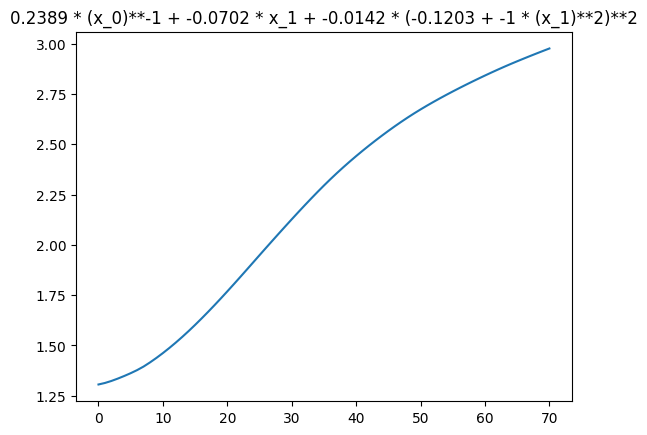

In [6]:
plt.plot(solutions[10]['solution'][:,1])
plt.title(solutions[10]['equations'][1])
plt.show()

In [8]:
def parse_system(system):
    """Parse ODE system using SymPy."""
    equations = [eq.strip() for eq in system.split(',')]
    expressions = []
    
    vars = []
    for eq in equations:
        var = eq.split('/')[0].strip()[1:]
        vars.append(var)
    
    for eq in equations:
        right = eq.split('=')[1].strip()
        expressions.append(sp.sympify(right))
    
    return sp.lambdify(vars, expressions, modules='numpy')

def integrate_ode(y0, times, system, events=None, debug=False):
    """Integrate an ODE system."""
    system_fn = parse_system(system)
    
    try:
        sol = scipy.integrate.solve_ivp(
            lambda t, y: system_fn(*y),
            (min(times), max(times)),
            y0,
            t_eval=times,
            events=events
        )
        return sol.y.T
            
    except Exception as e:
        if debug:
            import traceback
            print(traceback.format_exc())
        return None

# Generate two types of systems

In [30]:
def solve_simple(v_range, y0=np.array([1.0,1.0]), t=np.linspace(0, 10, 100)):
    solutions = []
    template = "dx/dt = {},dy/dt={}"

    for k in v_range:
        for b in v_range:
            system = template.format(k,b)
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (k,b,),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

def solve_ho(omega_range, gamma_range, y0=np.array([1.0, 1.0]), t=np.linspace(0, 10, 100)):
    solutions = []
    template = "dx/dt = y, dy/dt = -{}*x - {}*y"
    for omega in omega_range:
        for gamma in gamma_range:
            system = template.format(omega**2, gamma)
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (omega, gamma),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

k_range = np.linspace(-2.0, 2.0, 100) # linear coeficient range
simp_solutions = solve_simple(k_range)

omega_range = np.linspace(0.1, 5.0, 100)  # natural frequency
gamma_range = np.linspace(0.1, 5.0, 100)  # damping
ho_solutions = solve_ho(omega_range, gamma_range)

print(len(ho_solutions))
print(len(simp_solutions))


10000
10000


In [ ]:
def solve_simple(v_range, y0=np.array([1.0,1.0]), t=np.linspace(0, 10, 100)):
    solutions = []
    template = "dx/dt = {},dy/dt={}"

    for k in v_range:
        for b in v_range:
            system = template.format(k,b)
            solution = integrate_ode(y0, t, system)
            if solution is not None:
                solutions.append({
                    'params': (k,b,),
                    'equations': system,
                    'solution': solution,
                    'time_points': t
                })
    return solutions

k_range = np.linspace(-2.0, 2.0, 10) # linear coeficient range
simp_solutions = solve_simple(k_range)

In [28]:
solutions = []
template = "dx/dt =1,dy/dt=0.1"
y0=np.array([1.0, 0.0])
t=np.linspace(0, 10, 100)
solution = integrate_ode(y0, t, template)

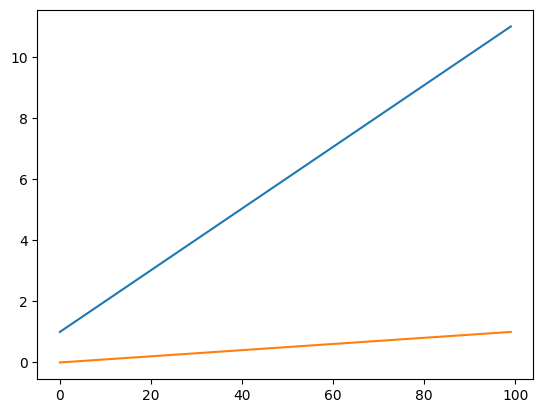

In [29]:
plt.plot(solution)
plt.show()

In [31]:
with open('../data/solutions/two_systems_solutions.pkl', 'wb') as f:
    pickle.dump(ho_solutions+simp_solutions, f)

In [32]:
# Data use sample

In [33]:
with open('../data/solutions/two_systems_solutions.pkl', 'rb') as f:
    solutions = pickle.load(f)

In [34]:
len(solutions)

20000

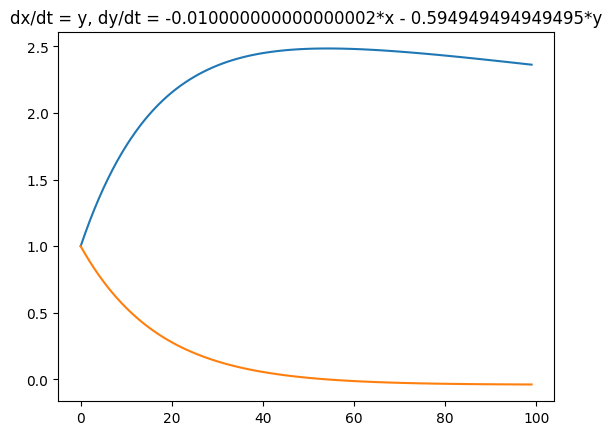

In [40]:
plt.plot(solutions[10]['solution'])
plt.title(solutions[10]['equations'])
plt.show()